In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [2]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [3]:
from cued_sf2_lab.lbt import pot_ii

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [4]:
# your code here
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.dct import regroup

C8 = dct_ii(8)

N = 8
Pf, Pr = pot_ii(N)

t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)  # idct

Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

print("Maximum Absolute Error (Zp-X): ", np.max(np.abs((Zp - X))), "bits" )

Maximum Absolute Error (Zp-X):  6.963318810448982e-13 bits


## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

Scaling factor: 1.0
Optimal step size: 23.369711692670602
Compression ratio:  3.019471133656249 

Scaling factor: 1.0256410256410255
Optimal step size: 23.595367772839563
Compression ratio:  3.0387768954854644 

Scaling factor: 1.0512820512820513
Optimal step size: 23.81436810241484
Compression ratio:  3.0572103567761437 

Scaling factor: 1.0769230769230769
Optimal step size: 24.024135845607816
Compression ratio:  3.0706460721418383 

Scaling factor: 1.1025641025641026
Optimal step size: 24.220607663971187
Compression ratio:  3.081606688094177 

Scaling factor: 1.1282051282051282
Optimal step size: 24.401390890566592
Compression ratio:  3.0942395931811446 

Scaling factor: 1.1538461538461537
Optimal step size: 24.57330172922739
Compression ratio:  3.1057045155801903 

Scaling factor: 1.1794871794871795
Optimal step size: 24.745954711113015
Compression ratio:  3.110337065410769 

Scaling factor: 1.205128205128205
Optimal step size: 24.897314356250988
Compression ratio:  3.11726844783027

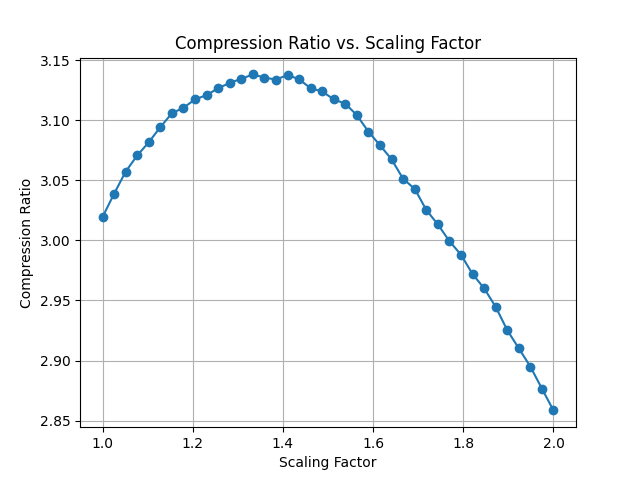

In [18]:
# your code here
from scipy.optimize import minimize_scalar
from cued_sf2_lab.laplacian_pyramid import bpp

def dctbpp(Yr, N):
    # Your code here
    total_bits = 0
    d, d = np.shape(Yr)
    step = d//N
    for i in range(0, d, step):
        for j in range(0, d, step):
            Ys = Yr[i:i+step, j:j+step] 
            bits = bpp(Ys) * Ys.size
            total_bits += bits 
    return total_bits

def find_optimal_step_size(X, s, step):
    def mse_diff(opt_step):
            
        Xq = quantise(X, step)
        optimalMSE = np.std(X - Xq) # direct quantisation 

        N = 8
        Pf, Pr = pot_ii(N, s)

        t = np.s_[N//2:-N//2] 
        Xp = X.copy() 
        Xp[t,:] = colxfm(Xp[t,:], Pf)
        Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

        Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
        Yq = quantise(Y, opt_step)           # quantisation
        Yr = regroup(Yq, N)/N                  # regroup
        Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction

        Zp = Z.copy() 
        Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
        Zp[t,:] = colxfm(Zp[t,:], Pr.T)

        MSE = np.std(Zp - X)

        MSEdiff = abs(MSE - optimalMSE)
        return MSEdiff
    
    res = minimize_scalar(mse_diff, bounds=(1, 256), method='bounded')
    minMSE = res.fun  # minimum
    minstep = res.x  # minimizer
    return minstep, minMSE

scaling_factors = []
compression_ratios = []
for s in np.linspace(1, 2, 40):

    N = 8
    Pf, Pr = pot_ii(N, s)
    opt_step = find_optimal_step_size(X, s, 17)[0]

    t = np.s_[N//2:-N//2] 
    Xp = X.copy() 
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
    Yq = quantise(Y, opt_step)           # quantisation
    Yr = regroup(Yq, N)/N                  # regroup
    Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction

    Zp = Z.copy() 
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)

    tot_bits_comp = dctbpp(Yr, N)
    tot_bits_direct = bpp(Xq) * Xq.size
    compression_ratio = tot_bits_direct / tot_bits_comp
    print(f"Scaling factor: {s}")
    print(f"Optimal step size: {opt_step}")
    print("Compression ratio: ", compression_ratio, "\n")

    scaling_factors.append(s)
    compression_ratios.append(compression_ratio)

plt.figure()
plt.plot(scaling_factors, compression_ratios, marker='o', linestyle='-')
plt.xlabel('Scaling Factor')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs. Scaling Factor')
plt.grid(True)
plt.show()

In [19]:
s = 1.4
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]

t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction

Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

tot_bits_comp = dctbpp(Yr, N)
tot_bits_direct = bpp(Xq) * Xq.size
compression_ratio = tot_bits_direct / tot_bits_comp
print(f"Scaling factor: {s}")
print(f"Optimal step size: {opt_step}")
print("Compression ratio: ", compression_ratio, "\n")


Scaling factor: 1.4
Optimal step size: 25.865897857587402
Compression ratio:  3.1320475531971494 



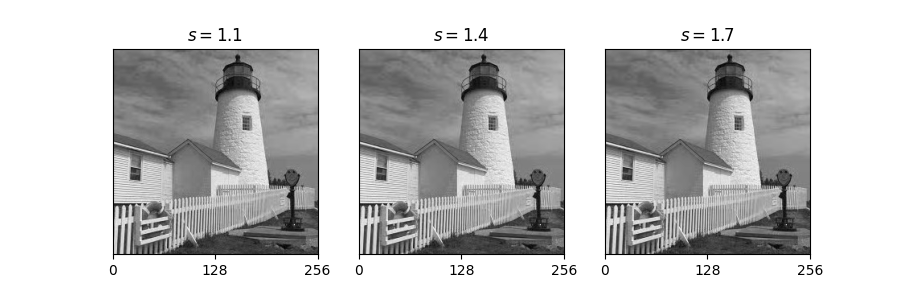

In [22]:
s = 1.1
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp11 = Zp.copy()

s = 1.4
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp14 = Zp.copy()

s = 1.7
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp17 = Zp.copy()

titles = ["Zp\ (s=1.1)", "Zp\ (s=1.4)", "Zp\ (s=1.7)"]
imgs = [Zp11, Zp14, Zp17]
fig, axs = plt.subplots(1, 3, figsize=(9, 3),
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

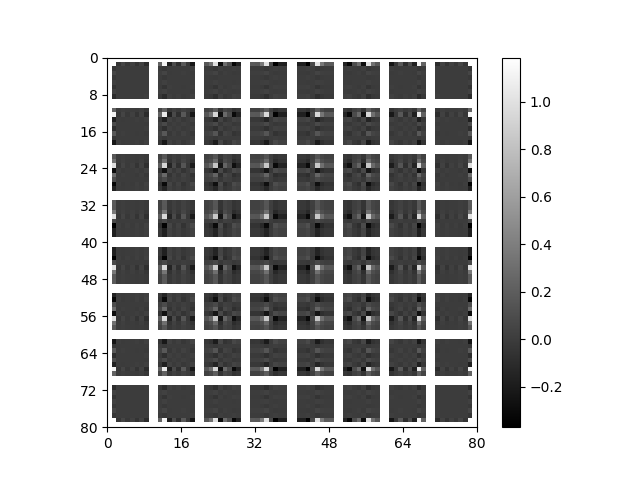

In [20]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

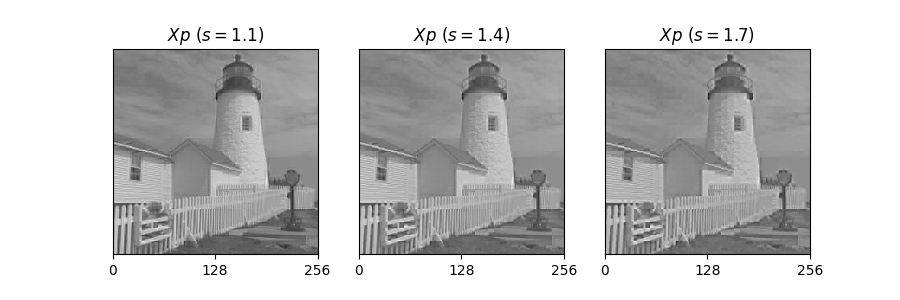

In [23]:
# your code here
s = 1.1
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Xp = Xp*0.5
Xp11 = Xp.copy()

s = 1.4
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Xp = Xp*0.5
Xp14 = Xp.copy()

s = 1.7
N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Xp = Xp*0.5
Xp17 = Xp.copy()

titles = ["Xp\ (s=1.1)", "Xp\ (s=1.4)", "Xp\ (s=1.7)"]
imgs = [Xp11, Xp14, Xp17]
fig, axs = plt.subplots(1, 3, figsize=(9, 3),
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

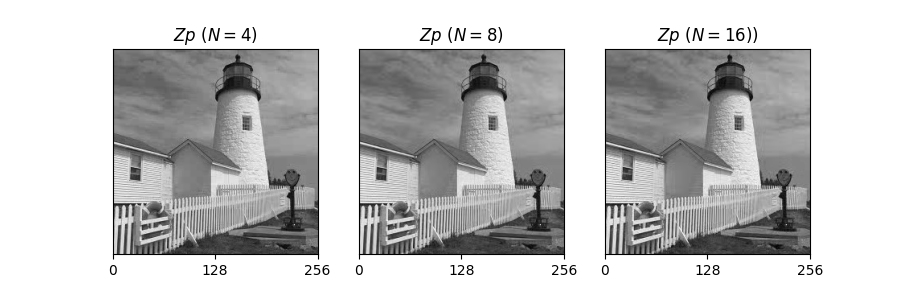

In [25]:
# your code here

s = 1.4

N = 4
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp4 = Zp.copy()

N = 8
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp8 = Zp.copy()

N = 16
Pf, Pr = pot_ii(N, s)
opt_step = find_optimal_step_size(X, s, 17)[0]
t = np.s_[N//2:-N//2] 
Xp = X.copy() 
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T       # dct
Yq = quantise(Y, opt_step)           # quantisation
Yr = regroup(Yq, N)/N                  # regroup
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)  # reconstruction
Zp = Z.copy() 
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
Zp16 = Zp.copy()

titles = ["Zp\ (N=4)", "Zp\ (N=8)", "Zp\ (N=16))"]
imgs = [Zp4, Zp8, Zp16]
fig, axs = plt.subplots(1, 3, figsize=(9, 3),
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

